In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
with open('models/rf_home.pkl', 'rb') as f:
    home_md = pickle.load(f)

with open('models/rf_away.pkl', 'rb') as f:
    away_md = pickle.load(f)

In [3]:
teams_data = pd.read_csv("data/new_model.csv")

In [4]:
['away_weight_goals','home_weight_goals_suf','home_weight_points','away_weight_points']
["home_weight_goals", "away_weight_goals_suf", 'home_weight_points','away_weight_points']

['home_weight_goals',
 'away_weight_goals_suf',
 'home_weight_points',
 'away_weight_points']

In [5]:
def find_team_features(home, away):
    home_infos = teams_data[(teams_data.home_team == home) | (teams_data.away_team == home)].tail(1)
    if home_infos.home_team.values[0] == home:
        home_goals_scored = home_infos["home_goals_mean"].values[0]
        home_goals_suf = home_infos["home_goals_suf_mean"].values[0]
        home_points_made = home_infos["home_game_points_mean"].values[0]
        home_rank = home_infos["rank_home"].values[0]
    else:
        home_goals_scored = home_infos["away_goals_mean"].values[0]
        home_goals_suf = home_infos["away_goals_suf_mean"].values[0]
        home_points_made = home_infos["away_game_points_mean"].values[0]
        home_rank = home_infos["rank_away"].values[0]
        
    
    away_infos = teams_data[(teams_data.home_team == away) | (teams_data.away_team == away)].tail(1)
    if away_infos.home_team.values[0] == away:
        away_goals_scored = away_infos["home_goals_mean"].values[0]
        away_goals_suf = away_infos["home_goals_suf_mean"].values[0]
        away_points_made = away_infos["home_game_points_mean"].values[0]
        away_rank = away_infos["rank_home"].values[0]
    else:
        away_goals_scored = away_infos["away_goals_mean"].values[0]
        away_goals_suf = away_infos["away_goals_suf_mean"].values[0]
        away_points_made = away_infos["away_game_points_mean"].values[0]
        away_rank = away_infos["rank_away"].values[0]

    #print(home_rank, away_rank)
    rank_dif = home_rank - away_rank
    ht_features = [
        home_goals_scored*rank_dif,
        away_goals_suf*rank_dif,
        home_points_made*rank_dif,
        away_points_made*rank_dif
    ]
    
    at_features = [
        away_goals_scored*rank_dif,
        home_goals_suf*rank_dif,
        home_points_made*rank_dif,
        away_points_made*rank_dif
    ]
    return ht_features, at_features

In [6]:
g, s = find_team_features("Germany", "Scotland")

In [7]:
xg_g = home_md.predict([g])[0]

In [8]:
xg_s = away_md.predict([s])[0]

In [9]:
from scipy.stats import poisson

In [10]:
poisson_probs_g = poisson.pmf(np.arange(0, 10), xg_g)
poisson_probs_s = poisson.pmf(np.arange(0, 10), xg_s)

In [11]:
def plot_poisson(x, poisson_probs, team):
    plt.figure(figsize=(10, 6))
    plt.bar(x, poisson_probs, alpha=0.6, color='blue')
    plt.plot(x, poisson_probs, 'bo', ms=8)
    plt.title(f'Poisson Distribution - {team}')
    plt.xlabel('Number of Events')
    plt.ylabel('Probability')
    plt.grid(True)
    plt.show()

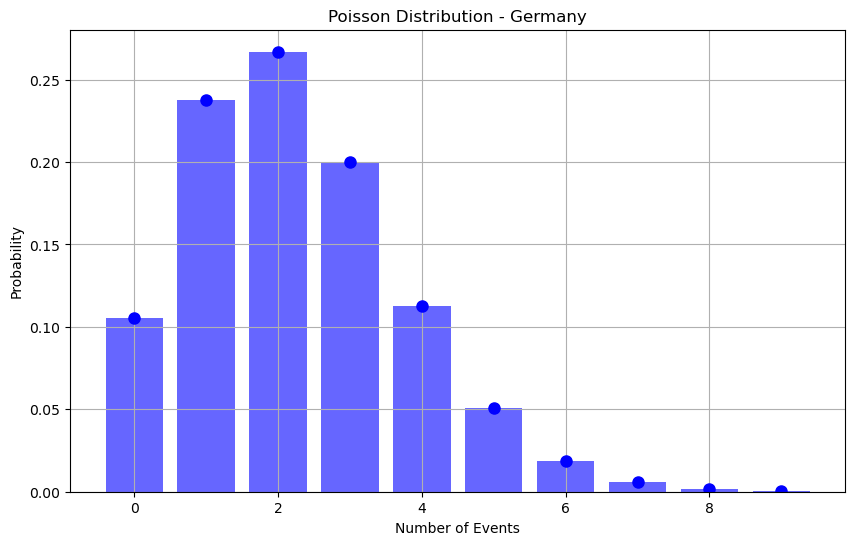

In [12]:
plot_poisson(np.arange(0,10), poisson_probs_g, "Germany")

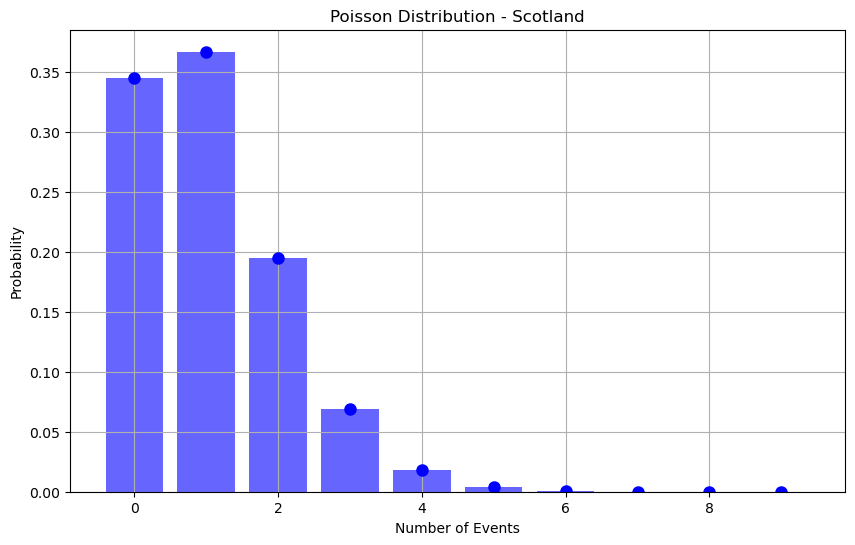

In [13]:
plot_poisson(np.arange(0,10), poisson_probs_s, "Scotland")

In [14]:
res_track = np.zeros((10,10))

for i in range(len(poisson_probs_g)):
    for j in range(len(poisson_probs_s)):
        res_prob = poisson_probs_g[i]*poisson_probs_s[j]
        res_track[j][i] = res_prob

In [15]:
poisson_probs_g

array([0.10562859, 0.23743471, 0.26685598, 0.19994863, 0.11236244,
       0.05051425, 0.01892454, 0.00607701, 0.00170751, 0.00042646])

In [16]:
poisson_probs_s

array([3.45664070e-01, 3.67194749e-01, 1.95033264e-01, 6.90604904e-02,
       1.83405303e-02, 3.89658458e-03, 6.89882424e-04, 1.04693390e-04,
       1.39018148e-05, 1.64085881e-06])

In [17]:
res_df = pd.DataFrame(res_track)

In [18]:
res_df.columns = ["Germany " + str(a) for a in res_df.columns] 
res_df.index = ["Scotland " + str(a) for a in res_df.index] 

In [19]:
def style_specific_cells(x):
    color = ''
    
    df_styled = pd.DataFrame('', index=x.index, columns=x.columns)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            if i == j:
                color = 'background-color: yellow'
            elif j > i:
                color = 'background-color: lightgreen'
            else:
                color = 'background-color: lightcoral'
            df_styled.iloc[i, j] = color
    return df_styled


In [20]:
res_df.style.format("{:.2%}").apply(style_specific_cells, axis=None)

,Germany 0,Germany 1,Germany 2,Germany 3,Germany 4,Germany 5,Germany 6,Germany 7,Germany 8,Germany 9
Scotland 0,3.65%,8.21%,9.22%,6.91%,3.88%,1.75%,0.65%,0.21%,0.06%,0.01%
Scotland 1,3.88%,8.72%,9.80%,7.34%,4.13%,1.85%,0.69%,0.22%,0.06%,0.02%
Scotland 2,2.06%,4.63%,5.20%,3.90%,2.19%,0.99%,0.37%,0.12%,0.03%,0.01%
Scotland 3,0.73%,1.64%,1.84%,1.38%,0.78%,0.35%,0.13%,0.04%,0.01%,0.00%
Scotland 4,0.19%,0.44%,0.49%,0.37%,0.21%,0.09%,0.03%,0.01%,0.00%,0.00%
Scotland 5,0.04%,0.09%,0.10%,0.08%,0.04%,0.02%,0.01%,0.00%,0.00%,0.00%
Scotland 6,0.01%,0.02%,0.02%,0.01%,0.01%,0.00%,0.00%,0.00%,0.00%,0.00%
Scotland 7,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
Scotland 8,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
Scotland 9,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%


In [21]:
def find_probs(poisson_home, poisson_away):
    home_probs = []
    away_probs = []
    
    draw_probs = []
    
    for i in range(len(poisson_home)):
        for j in range(len(poisson_away)):
            res_prob = poisson_home[i]*poisson_away[j]
            
            if i == j:
                draw_probs.append(res_prob)
            elif i > j:
                home_probs.append(res_prob)
            elif j > i:
                away_probs.append(res_prob)
            #res_track[j][i] = res_prob
    
    
    return sum(home_probs), sum(draw_probs), sum(away_probs), poisson_home.tolist().index(max(poisson_home.tolist())), poisson_away.tolist().index(max(poisson_away.tolist()))

In [22]:
gw, draw, sw, g1, g2 = find_probs(poisson_probs_g, poisson_probs_s)

In [23]:
print(f"Germany Wins: {gw:.2%}")
print(f"Draw: {draw:.2%}")
print(f"Scotland Wins: {sw:.2%}")

Germany Wins: 64.10%
Draw: 19.18%
Scotland Wins: 16.71%


In [24]:
find_probs(poisson_probs_g, poisson_probs_s)

(0.641003760747257, 0.1918224649591825, 0.16705370704018138, 2, 1)

## Complete sim

With the model done, I'll simulate each game in the UEFA Euro to find the most likely results

In [25]:
euro = pd.read_csv("data/euro_matches.csv")

In [26]:
group_phase = euro.dropna(subset='home_team')

In [27]:
r1 = group_phase.head(12).copy()
r1["Group"] = ['A', 'A', 'B', 'B', 'C', 'C', 'D', 'D', 'E', 'E', 'F', 'F']

In [28]:
groups = r1.Group.drop_duplicates().values

In [29]:
group_dict = {}
for g in groups:
    teams1 = r1[r1.Group == g].home_team.values.tolist()
    teams2 = r1[r1.Group == g].away_team.values.tolist()
    teams = teams1+teams2
    group_dict[g] = {a: [0, 0, 0] for a in teams}

In [30]:
group_phase['Group'] = group_phase.home_team.apply(lambda x: r1[r1.home_team == x].Group.values[0] if len(r1[r1.home_team == x])>0 else r1[r1.away_team == x].Group.values[0])

C:\Users\sergi\AppData\Local\Temp\ipykernel_20128\2649806274.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_phase['Group'] = group_phase.home_team.apply(lambda x: r1[r1.home_team == x].Group.values[0] if len(r1[r1.home_team == x])>0 else r1[r1.away_team == x].Group.values[0])


In [31]:
from tqdm import tqdm

In [32]:
for i, vals in group_phase.iterrows():
    home = vals['home_team']
    away = vals['away_team']
    
    # SIM 1 HOME x AWAY
    h, a = find_team_features(home, away)

    xg_h = home_md.predict([h])[0]
    xg_a = away_md.predict([a])[0]

    poisson_probs_h = poisson.pmf(np.arange(0, 10), xg_h)
    poisson_probs_a = poisson.pmf(np.arange(0, 10), xg_a)

    hw, draw, aw, g1, g2 = find_probs(poisson_probs_h, poisson_probs_a)
    hw -= 0.05
    draw +=0.1
    aw -= 0.05
    
    if max([hw, draw, aw]) == hw:
        home_points=3
        away_points=0
    elif max([hw, draw, aw]) == aw:
        home_points=0
        away_points=3
    else:
        home_points=1
        away_points=1
    
    grp = group_dict[vals['Group']]
    
    group_dict[vals['Group']][home] = [grp[home][0]+home_points, grp[home][1]+g1, grp[home][2]+g2]
    group_dict[vals['Group']][away] = [grp[away][0]+away_points, grp[home][1]+g2, grp[home][2]+g1]

    print(f"{home} Wins: {hw:.2%}")
    print(f"Draw: {draw:.2%}")
    print(f"{away} Wins: {aw:.2%}")
    print(f"most prob result {home} {g1} - {g2} {away}")
    
    
    print("------------------------------------------")


Germany Wins: 59.10%
Draw: 29.18%
Scotland Wins: 11.71%
most prob result Germany 2 - 1 Scotland
------------------------------------------
Hungary Wins: 23.83%
Draw: 41.32%
Switzerland Wins: 34.85%
most prob result Hungary 0 - 1 Switzerland
------------------------------------------
Spain Wins: 49.67%
Draw: 34.17%
Croatia Wins: 16.16%
most prob result Spain 1 - 0 Croatia
------------------------------------------
Italy Wins: 64.64%
Draw: 30.74%
Albania Wins: 4.61%
most prob result Italy 1 - 0 Albania
------------------------------------------
Slovenia Wins: 15.48%
Draw: 38.52%
Denmark Wins: 45.99%
most prob result Slovenia 0 - 1 Denmark
------------------------------------------
Serbia Wins: 20.75%
Draw: 37.85%
England Wins: 41.40%
most prob result Serbia 0 - 1 England
------------------------------------------
Poland Wins: 12.78%
Draw: 36.12%
Netherlands Wins: 51.10%
most prob result Poland 0 - 1 Netherlands
------------------------------------------
Austria Wins: 15.58%
Draw: 35.86%


In [33]:
group_dfs = []

In [34]:
for g in group_dict.keys():
    gdf = pd.DataFrame(group_dict[g]).T
    
    gdf.columns = ["Points", "GF", "GA"]
    gdf["SG"] = gdf["GF"] - gdf["GA"]
    
    gdf = gdf.sort_values(["Points", "SG", "GF", "GA"], ascending=False)
    group_dfs.append(gdf)

In [35]:
thirds = pd.DataFrame()
for g in group_dfs:
    thirds = pd.concat([thirds, g.head(3).tail(1)])

thirds = thirds.sort_values(["Points", "SG", "GF", "GA"], ascending=False)

In [36]:
classified = thirds.head(4).index.values

In [37]:
def style_clf(row, df, n):
    if row.name in df.head(n).index.values:
        return ['background-color: lightgreen'] * len(row)
    else:
        return [''] * len(row)

In [38]:
for g in group_dfs:
    if g.index.values[2] in classified:
        display(g.style.apply(lambda x: style_clf(x, g, 3), axis=1))
    else:
        display(g.style.apply(lambda x: style_clf(x, g, 2), axis=1))

,Points,GF,GA,SG
Germany,9,4,2,2
Switzerland,2,5,3,2
Hungary,2,5,5,0
Scotland,2,4,4,0


,Points,GF,GA,SG
Spain,7,3,3,0
Croatia,6,3,2,1
Italy,4,4,3,1
Albania,0,2,3,-1


,Points,GF,GA,SG
England,9,4,2,2
Denmark,6,2,2,0
Serbia,3,2,3,-1
Slovenia,0,4,4,0


,Points,GF,GA,SG
Netherlands,9,3,2,1
France,6,5,3,2
Poland,3,5,5,0
Austria,0,3,3,0


,Points,GF,GA,SG
Belgium,9,3,3,0
Ukraine,4,2,3,-1
Romania,2,3,4,-1
Slovakia,1,2,3,-1


,Points,GF,GA,SG
Portugal,7,3,4,-1
Turkey,5,4,4,0
Czech Republic,4,3,3,0
Georgia,0,1,4,-3


In [39]:
thirds.style.apply(lambda x: style_clf(x, thirds, 4), axis=1)

,Points,GF,GA,SG
Italy,4,4,3,1
Czech Republic,4,3,3,0
Poland,3,5,5,0
Serbia,3,2,3,-1
Hungary,2,5,5,0
Romania,2,3,4,-1


In [40]:
combs = pd.read_html("https://en.wikipedia.org/wiki/UEFA_Euro_2024_knockout_stage")[0]

In [41]:
combs = combs.dropna(how='all')
combs.columns = ['A', 'B', 'C', 'D', 'E', 'F', '1B', '1C', '1E', '1F', 'drop']
combs.drop('drop', axis=1, inplace=True)

In [42]:
third_comb = ['B', 'C', 'D', 'F']

In [43]:
third_seconds = combs.dropna(subset=third_comb).values[0][6:]

In [44]:
fixed_seconds = ['2C', '2E', '2F', '2B']

In [45]:
seconds = []
for i in range(0, 8):
    if i%2 == 0:
        seconds.append(third_seconds[i//2])
    else:
        seconds.append(fixed_seconds[i//2])

In [46]:
firsts = ['1B', '1A', '1F', '2D', '1E', '1D', '1C', '2A']

In [47]:
seconds

['3F', '2C', '3D', '2E', '3C', '2F', '3B', '2B']

In [48]:
def letter_to_number(letter):
    letter = letter.lower()  # Convert to lowercase to handle both cases
    return ord(letter) - ord('a')

In [49]:
duels = [] 
for f, s in zip(firsts, seconds):
    pos, grp = int(f[0]), letter_to_number(f[1])
    first = group_dfs[grp].head(pos).tail(1).index.values[0]
    
    pos, grp = int(s[0]), letter_to_number(s[1])
    second = group_dfs[grp].head(pos).tail(1).index.values[0]
    
    duels.append([first, second])

In [50]:
playoffs = {"Round of 16": [], "Quarter-Final": [], "Semi-Final": [], "Final": []}

In [51]:
#playoffs['Round of 16'] = duels

In [52]:
def sim_game(t1, t2):
    h, a = find_team_features(t1, t2)

    xg_h = home_md.predict([h])[0]
    xg_a = away_md.predict([a])[0]

    poisson_probs_h = poisson.pmf(np.arange(0, 10), xg_h)
    poisson_probs_a = poisson.pmf(np.arange(0, 10), xg_a)

    hw, draw, aw, g1, g2 = find_probs(poisson_probs_h, poisson_probs_a)
    
    return hw, draw, aw

In [53]:
#sim_game(t2, t1)

In [54]:
for phase in playoffs.keys():
    playoffs[phase] = duels
    next_phase = []
    for i in range(len(playoffs[phase])):
        game = playoffs[phase][i]
        t1, t2 = game[0], game[1]
        
        h1, d1, a1 = sim_game(t1, t2)
        a2, d2, h2 = sim_game(t2, t1)
        
        hw = (h1+h2)/2
        draw = (d1+d2)/2
        aw = (a1+a2)/2
        
        if max([hw, aw]) == hw:
            passed = t1
        else:
            passed = t2
        
        print(f"{t1} Wins: {hw:.2%}")
        print(f"Draw: {draw:.2%}")
        print(f"{t2} Wins: {aw:.2%}")
        #print(f"most prob result {t1} {g1} - {g2} {t2}")
    
        playoffs[phase][i].append([hw, aw])

        print("------------------------------------------")
        
        if i%2 == 0:
            next_phase.append([passed])
        else:
            next_phase[i//2].append(passed)
    duels = next_phase

Spain Wins: 61.39%
Draw: 22.58%
Czech Republic Wins: 16.01%
------------------------------------------
Germany Wins: 43.59%
Draw: 25.50%
Denmark Wins: 30.91%
------------------------------------------
Portugal Wins: 61.11%
Draw: 22.62%
Poland Wins: 16.26%
------------------------------------------
France Wins: 65.62%
Draw: 20.20%
Ukraine Wins: 14.16%
------------------------------------------
Belgium Wins: 59.73%
Draw: 22.66%
Serbia Wins: 17.60%
------------------------------------------
Netherlands Wins: 53.09%
Draw: 25.20%
Turkey Wins: 21.70%
------------------------------------------
England Wins: 47.30%
Draw: 23.96%
Italy Wins: 28.74%
------------------------------------------
Switzerland Wins: 31.94%
Draw: 26.03%
Croatia Wins: 42.04%
------------------------------------------
Spain Wins: 38.36%
Draw: 24.17%
Germany Wins: 37.47%
------------------------------------------
Portugal Wins: 30.92%
Draw: 24.28%
France Wins: 44.80%
------------------------------------------
Belgium Wins: 

In [55]:
playoffs

{'Round of 16': [['Spain',
   'Czech Republic',
   [0.6139485354409572, 0.16014284753827207]],
  ['Germany', 'Denmark', [0.4358503941359757, 0.30911631272190393]],
  ['Portugal', 'Poland', [0.6111437427216178, 0.16262982356269282]],
  ['France', 'Ukraine', [0.6561802557643402, 0.14163809314688314]],
  ['Belgium', 'Serbia', [0.5972818231258941, 0.17602064800924508]],
  ['Netherlands', 'Turkey', [0.5309228288043137, 0.2170199080164148]],
  ['England', 'Italy', [0.47297492956031, 0.2873890157526]],
  ['Switzerland', 'Croatia', [0.3193513404292764, 0.4203800323087652]]],
 'Quarter-Final': [['Spain',
   'Germany',
   [0.38355945415853787, 0.374713400241404]],
  ['Portugal', 'France', [0.3091574094747541, 0.448021584235085]],
  ['Belgium', 'Netherlands', [0.4391330744693578, 0.29051397285455455]],
  ['England', 'Croatia', [0.49366059193432454, 0.25769049217455603]]],
 'Semi-Final': [['Spain', 'France', [0.3260048712190167, 0.44976594727561675]],
  ['Belgium', 'England', [0.394848857195794, 0

In [56]:
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

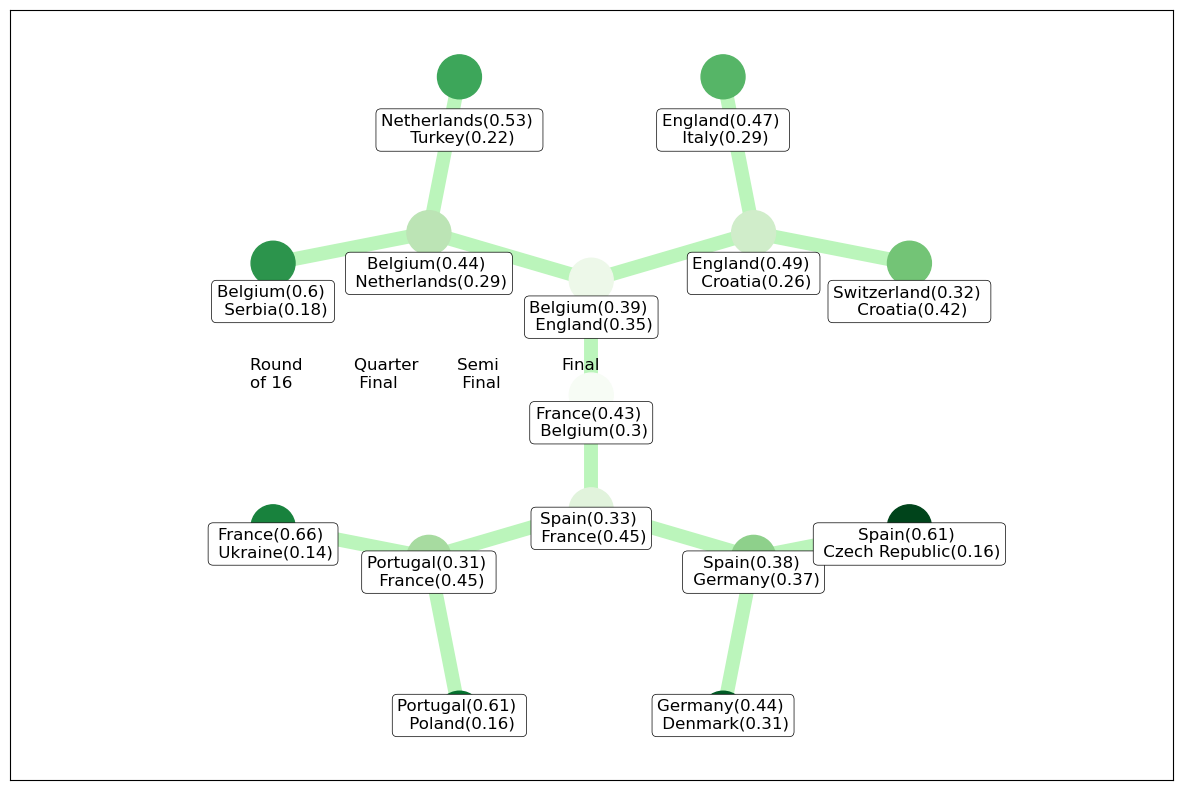

In [58]:
plt.figure(figsize=(15, 10))
G = nx.balanced_tree(2, 3)



labels = []


for p in playoffs.keys():
    for game in playoffs[p]:
        label = f"{game[0]}({round(game[2][0], 2)}) \n {game[1]}({round(game[2][1], 2)})"
        labels.append(label)
    
labels_dict = {}
labels_rev = list(reversed(labels))

for l in range(len(list(G.nodes))):
    labels_dict[l] = labels_rev[l]


pos=graphviz_layout(G, prog='twopi')
pos = {int(n): pos[n] for n in pos.keys()}

labels_pos = {int(n): (k[0], k[1]-0.08*k[1]) for n,k in pos.items()}
center  = pd.DataFrame(pos).mean(axis=1).mean()
    


nx.draw_networkx(G, pos = pos, with_labels=False, node_color=range(15), edge_color="#bbf5bb", width=10, font_weight='bold',cmap=plt.cm.Greens, node_size=1000)
nx.draw_networkx_labels(G, pos = labels_pos, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=.5, alpha=1),labels=labels_dict)
texts = ["Round \nof 16", "Quarter \n Final", "Semi \n Final", "Final\n"]
pos_y = pos[0][1] + 55
for text in reversed(texts):
    pos_x = center
    pos_y -= 65
    plt.text(pos_y, pos_x, text, fontsize = 12)

plt.axis('equal')
plt.show()